<a href="https://colab.research.google.com/github/travislatchman/Electrocardiograms-and-Neural-Networks/blob/main/ECG_LSTM_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Electrocardiograms and Neural Networks

we will try to predict heart arrhythmia with LSTMs and 1-D CNNs.

We will use MIT-BIH Arrythmia dataset (https://www.physionet.org/content/mitdb/1.0.0/).
It consists of ECG recordings of several patients with sample rate 360 Hz. Experts annotated/classified specific points in the signals as normal, abnormal, or non beat.



In [ ]:
# Import lib
import os
%pip install wfdb
import wfdb
import numpy as np
import pandas as pd
import urllib.request
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.signal
from pywt import wavedec, dwt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 KB 3.6 MB/s eta 0:00:00
  Attempting uninstall: SoundFile
    Found existing installation: soundfile 0.12.1
    Uninstalling soundfile-0.12.1:
      Successfully uninstalled soundfile-0.12.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
librosa 0.10.0.post2 requires soundfile>=0.12.1, but you have soundfile 0.11.0 which is incompatible.


In [ ]:
# Load database
urllib.request.urlretrieve('https://physionet.org/static/published-projects/mitdb/mit-bih-arrhythmia-database-1.0.0.zip', './mba_dataset.zip')
!unzip mba_dataset.zip -d mba_dataset
path_dataset='mba_dataset/mit-bih-arrhythmia-database-1.0.0/'

Archive:  mba_dataset.zip
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/100.atr  
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/100.dat  
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/100.hea  
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/100.xws  
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/101.atr  
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/101.dat  
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/101.hea  
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/101.xws  
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/102-0.atr  
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/102.atr  
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/102.dat  
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/102.hea  
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/102.xws  
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/103.atr  
  infl

**Explore database**

We will primarily use \<patientID>.atr files (patientID is being 100, 101, etc.). There are 48 patients with a 30 minutes of recording for each.
For '100' patient, let us check what all annotations are present in his/her signal. Run the code below.

In [ ]:
# We provide function for loading an ECG file
def load_ECG_file(path):
    '''
    Input: path for patient files (excluding extension)
    Output: ECG signal, symbols (labels), indices for such symbols
    '''
    record = wfdb.rdrecord(path)
    annotation = wfdb.rdann(path, 'atr')
    signal = record.p_signal[:,0]    # ECG signal
    symbol = annotation.symbol  # symbols
    index = annotation.sample  # annotation index
    return signal, symbol, index
signal, symbol, index = load_ECG_file(os.path.join(path_dataset, '100'))  # check for yourself "signal" is ~30 min duration
print(f'Length of signal: {len(signal)}')  # ECG signal length (in terms of samples and NOT seconds); think why this corresponds to ~30 minutes of signal
print(f'Annotation symbols: {symbol}')  # annotation symbols
print(f'Annotation indices: {index}')  # annotion indices of symbols for patient

Length of signal: 650000
Annotation symbols: ['+', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'A', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N',

We can see a lot of 'N' symbols. It refers to "normal" heartbeat.
The list of abnormal symbols are provided below, which we will consider as "abnormal" beats in this lab.
Any other symbol encountered in the dataset refer to "non-beat" and you **must** skip them in data preparation.
For detailed explanation about symbols, refer to https://archive.physionet.org/physiobank/annotations.shtml

In [ ]:
# list of symbols for abnormal beats
abnormal = ['L','R','V','/','A','f','F','j','a','E','J','e','S']

**TASK 1 Data visualization**: Plot any random 10-second long portion of this ECG file (patient 100). Then plot any 1-second portion of this ECG file (patient 100) which has an abnormality approximately in the middle of the signal.

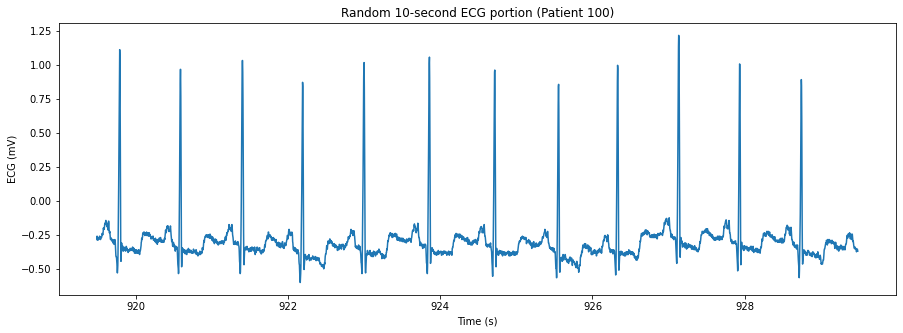

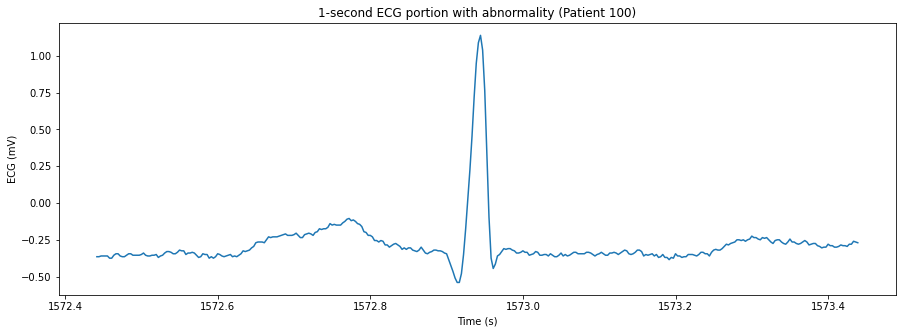

In [ ]:
# Your code here
import random
# Load the ECG data (replace 'path/to/your/data' with the actual path to your data)
record = wfdb.rdrecord(os.path.join(path_dataset, '100'))

# Get the signal and annotation data
signal = record.p_signal[:, 0]
annotations = wfdb.rdann(os.path.join(path_dataset, '100'), 'atr')

# Find the abnormal beats
abnormal_beats = [i for i, symbol in zip(annotations.sample, annotations.symbol) if symbol in ['V', 'A', 'F', 'S']]

# Plot a random 10-second portion of the ECG
start_sample = random.randint(0, len(signal) - 10 * record.fs)
end_sample = start_sample + 10 * record.fs
plt.figure(figsize=(15, 5))
plt.plot(np.arange(start_sample, end_sample) / record.fs, signal[start_sample:end_sample])
plt.xlabel('Time (s)')
plt.ylabel('ECG (mV)')
plt.title('Random 10-second ECG portion (Patient 100)')
plt.show()

# Plot a 1-second portion with an abnormal beat
abnormal_sample = random.choice(abnormal_beats)
start_sample = abnormal_sample - int(0.5 * record.fs)
end_sample = abnormal_sample + int(0.5 * record.fs)
plt.figure(figsize=(15, 5))
plt.plot(np.arange(start_sample, end_sample) / record.fs, signal[start_sample:end_sample])
plt.xlabel('Time (s)')
plt.ylabel('ECG (mV)')
plt.title('1-second ECG portion with abnormality (Patient 100)')
plt.show()

**TASK 2 Data preparation**: Training data or test data is usually represented by a matrix $X \in \mathbb{R}^{N\times D}$. N represents the number of training points, and D represents the data dimension. We will consider one data point as +/- 2 seconds sequence of samples centered around a Q wave (annotation). Therefore, $D = 4f$ , where $f$ is the sample rate. Your goal is to construct such data matrix $X$. Your function should also output the corresponding label vector $y \in \mathbb{R}^{N\times 1}$. Labels should be 0 for Normal and 1 for abnormal. You should get close to a total of 100k data points.  

**Here are the instructions for setting labels:**

**If your 4-second data contains at least one abnormal annotation, you need to set the label to 1.**



**Note 1:** Don't forget to ingore the non-beat symbols.

**Note 2:** Labels in abnormal list should all be set with label 1.

**Note 3:** The patients in the training set should be different from the patients in the test set. Split the patients roughly 70:30, or you can simply use the patient IDs that have been split into train/test which is given below.

In [ ]:
# Splitted ID
# training patient IDs
pts_train = ['100','101','102','103','104','105','106','107',
       '108','109','111','112','113','114','115','116',
       '117','118','119','121','122','123','124','200',
       '201','202','203','205','207','208','209','210']

# testing patient IDs
pts_test = ['212','213','214','215','217','219','220','221',
       '222','223','228','230','231','232','233','234']

In [ ]:
# Your code here

# def make_dataset():
#   '''
#   Output: X_train, y_train, X_test y_test
#   '''
#   pass

# print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

In [ ]:
def make_dataset(pts_train, pts_test):
    X_train = []
    y_train = []
    X_test = []
    y_test = []

    for patient_id in pts_train + pts_test:
        # Load the ECG data and annotations
        record = wfdb.rdrecord(f'{path_dataset}/{patient_id}')
        annotations = wfdb.rdann(f'{path_dataset}/{patient_id}', 'atr')

        # Get the signal and sample rate
        signal = record.p_signal[:, 0]
        fs = record.fs

        # Extract 4-second windows centered around each Q wave annotation
        window_size = 4 * fs
        for idx, label in zip(annotations.sample, annotations.symbol):
            # Ignore non-beat symbols
            if label not in ['N', 'V', 'A', 'F', 'S']:
                continue

            # Extract the window and label
            start = idx - window_size // 2
            end = idx + window_size // 2
            if start >= 0 and end <= len(signal):
                window = signal[start:end]
                y = 1 if label != 'N' else 0

                if patient_id in pts_train:
                    X_train.append(window)
                    y_train.append(y)
                else:
                    X_test.append(window)
                    y_test.append(y)

    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)


    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = make_dataset(pts_train, pts_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(53935, 1440) (53935, 1) (31407, 1440) (31407, 1)


**Task 3 Feature extraction**: You will use Signal Processing lib [scipy.signal](https://docs.scipy.org/doc/scipy/reference/signal.html) to extract features for training and testing data matrices. We will do short-time Fourier transform to extract the spectrogram of ECG signal.

**Note 1:** A common format of spectrogram is a graph with two geometric dimensions: one axis represents time, and the other axis represents frequency; a third dimension indicating the amplitude of a particular frequency at a particular time is represented by the intensity or color of each point in the image.

Examples of ECG spectrogram are shown below:

![ECG_spetrogram.jpg](https://d3i71xaburhd42.cloudfront.net/c86f76b6eeaa1ae92e5c96a68ca47d046fc01b2e/3-Figure2-1.png)

M. Salem, S. Taheri and J. Yuan, "ECG Arrhythmia Classification Using Transfer Learning from 2- Dimensional Deep CNN Features," 2018 IEEE Biomedical Circuits and Systems Conference (BioCAS), Cleveland, OH, USA, 2018, pp. 1-4, doi: 10.1109/BIOCAS.2018.8584808.


In [ ]:
def extract_features(X, fs=360, nperseg=64, noverlap=None):
    '''
    Input: X (N x D): Input data matrix
    Output: F (N x Frequecny x time): Feature matrix
    '''
    F = []
    for x in X:
        # Compute the short-time Fourier transform (STFT) of the signal
        f, t, Zxx = scipy.signal.stft(x, fs=fs, nperseg=nperseg, noverlap=noverlap)

        # Compute the magnitude of the STFT
        Sxx = np.abs(Zxx)

        # Add the spectrogram to the feature matrix
        F.append(Sxx)

    F = np.array(F)
    return F

F_train = extract_features(X_train)
F_test = extract_features(X_test)
print(F_train.shape, F_test.shape)

(53935, 33, 46) (31407, 33, 46)


**Task 4 Distribution and compensation for imbalance**: Plot the distribution of percentage of oberservations with normal and abnormal labels in training set. Is the dataset balanced? If not, how could you deal with this imbalanced dataset during training?

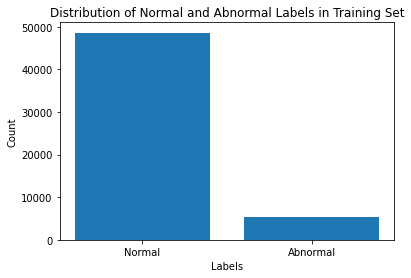

Percentage of Normal: 90.10%
Percentage of Abnormal: 9.90%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_distribution(y_train):
    unique_labels, counts = np.unique(y_train, return_counts=True)
    label_dict = {0: "Normal", 1: "Abnormal"}

    plt.bar(unique_labels, counts, tick_label=[label_dict[label] for label in unique_labels])
    plt.xlabel("Labels")
    plt.ylabel("Count")
    plt.title("Distribution of Normal and Abnormal Labels in Training Set")
    plt.show()

    percentage = counts / y_train.shape[0] * 100
    for label, perc in zip(unique_labels, percentage):
        print(f"Percentage of {label_dict[label]}: {perc:.2f}%")

plot_distribution(y_train)


To compensate for the imbalanced dataset during training, we can use a weighted loss function: Modify the loss function during training to give more importance to the minority class. This can be achieved by assigning class weights inversely proportional to their frequency in the dataset.

we can use techniques such as oversampling, undersampling, or a combination of both. Oversampling involves increasing the number of samples in the minority class (abnormal class in this case), while undersampling involves decreasing the number of samples in the majority class (normal class in this case). A combination of both involves both oversampling and undersampling.

**TASK 5 LSTM**: Now, we are going to train a classifier to detect abnormal ECG cycles. We will train a simplified version of the LSTM-based network described in one of the [previously cited papers](https://www.sciencedirect.com/science/article/pii/S0010482518300738?casa_token=qrJ6hAf9tkYAAAAA:7uXqrKY5WqUM6Mjc_qg7wJ4R6QA02BGFXP0o_pOKN09yB8JIXb7067JZWY88rZc8M1G6gkkA).

**Task 5.1:** Using Pytorch, create a single layer Bidirectional LSTM model. Followed by LSTM layer, you should have linear layer with sigmoid activation and a single output (we are predicting Normal/Abnormal).

**Task 5.2:** While creating your LSTM model, how could you validate your model in a real scientific experiment? (Describe and comment it in a text cell)

**Task 5.3:** Train and test your model, report your accuracy and F1-score on test set and train set. (You can find the definition and formula of accuracy, precision, recall-rate, and f1-score from this [link](https://towardsdatascience.com/the-f1-score-bec2bbc38aa6))

**Task 5.4:** What do you think is a way to increase the accuracy and F1-score? Try it and show if it is helpful.

**Note 1:** Print the loss function and accuracy while training to make sure your model works.

**Note 2:** You need to add a flattening layer after LSTM layer (and before linear layer).

**Note 3:** The output of LSTM in pytorch lib have a tuple outout, add the following GetLSTMOutput after your layer. If your model doesn't have this problem, you can ignore this.

In [ ]:
import torch
import torch.nn as nn

In [ ]:
from sklearn.utils import class_weight

# Calculate class weights
class_weights = class_weight.compute_sample_weight('balanced', y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float)

In [ ]:
class_weights2 = class_weight.compute_sample_weight('balanced', y_test)
class_weights2 = torch.tensor(class_weights2, dtype=torch.float)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class ECGClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(ECGClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.flatten(out[:, -1, :])
        out = self.fc(out)
        out = self.sigmoid(out)
        return out


In [ ]:
F_train.shape[-1]

46

In [ ]:
# Convert datasets to PyTorch tensors
F_train_tensor = torch.from_numpy(F_train).float()
F_test_tensor = torch.from_numpy(F_test).float()
y_train_tensor = torch.from_numpy(y_train).float()
y_test_tensor = torch.from_numpy(y_test).float()

5.2: In a real scientific experiment, we could validate the LSTM model by using a holdout validation set to evaluate the performance of the model on data that was not used during training. Also, cross-validation can be used to estimate the generalization performance of the model on a wider range of data. We can also compare the performance of the LSTM model to that of other models or methods on the same dataset and visualize the learned representations in the LSTM layer to gain insights into the features that are important for classification.

In [ ]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for features, labels in train_loader:
        features = features.to(device)
        labels = labels.to(device)

        batch_class_weights = class_weight.compute_sample_weight('balanced', labels.cpu().numpy())
        batch_class_weights = torch.tensor(batch_class_weights, dtype=torch.float).to(device)

        optimizer.zero_grad()
        output = model(features)
        loss = criterion(output.view(-1), labels.view(-1))
        weighted_loss = (loss * batch_class_weights).mean()
        weighted_loss.backward()
        optimizer.step()

        running_loss += weighted_loss.item()
        predicted = (output.view(-1) > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels.view(-1)).sum().item()

    accuracy = correct / len(train_loader.dataset)
    return running_loss / len(train_loader), accuracy


In [ ]:
def test(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            total_loss += loss.item()
            pred = (output > 0.5).float()
            correct += pred.eq(target.view_as(pred)).sum().item()

    accuracy = correct / len(test_loader.dataset)
    return total_loss / len(test_loader), accuracy

In [ ]:
# Define hyperparameters
input_size = F_train.shape[-1]
hidden_size = 64
num_layers = 1
num_classes = 1
learning_rate = 0.001
batch_size = 32
num_epochs = 50

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# Create DataLoader for the train and test datasets
train_dataset = TensorDataset(F_train_tensor, y_train_tensor)
test_dataset = TensorDataset(F_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
# Create the model, optimizer and loss function
model = ECGClassifier(input_size, hidden_size, num_layers, num_classes).to(device)
# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:


# Train the model
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_accuracy = test(model, test_loader, criterion, device)
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")



Epoch 1/50
Train Loss: 0.3277, Train Accuracy: 0.9010
Test Loss: 0.4611, Test Accuracy: 0.8369
Epoch 2/50
Train Loss: 0.3235, Train Accuracy: 0.9010
Test Loss: 0.4685, Test Accuracy: 0.8369
Epoch 3/50
Train Loss: 0.3233, Train Accuracy: 0.9010
Test Loss: 0.4661, Test Accuracy: 0.8369
Epoch 4/50
Train Loss: 0.3231, Train Accuracy: 0.9010
Test Loss: 0.4603, Test Accuracy: 0.8369
Epoch 5/50
Train Loss: 0.3224, Train Accuracy: 0.9010
Test Loss: 0.4506, Test Accuracy: 0.8369
Epoch 6/50
Train Loss: 0.3218, Train Accuracy: 0.9010
Test Loss: 0.4682, Test Accuracy: 0.8369
Epoch 7/50
Train Loss: 0.3215, Train Accuracy: 0.9010
Test Loss: 0.4669, Test Accuracy: 0.8369
Epoch 8/50
Train Loss: 0.3211, Train Accuracy: 0.9010
Test Loss: 0.4607, Test Accuracy: 0.8369
Epoch 9/50
Train Loss: 0.3168, Train Accuracy: 0.9017
Test Loss: 0.4625, Test Accuracy: 0.8369
Epoch 10/50
Train Loss: 0.3206, Train Accuracy: 0.9010
Test Loss: 0.4593, Test Accuracy: 0.8369
Epoch 11/50
Train Loss: 0.2845, Train Accuracy: 0

In [ ]:
from sklearn.metrics import f1_score

def f1_score_eval(model, test_loader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = (output > 0.5).float()

            y_true.extend(target.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())

    return f1_score(y_true, y_pred)



In [ ]:
f1_test = f1_score_eval(model, test_loader, device)
f1_train = f1_score_eval(model, train_loader, device)

print(f"F1-score on Train set: {f1_train:.4f}")
print(f"F1-score on Test set: {f1_test:.4f}")


F1-score on Train set: 0.9847
F1-score on Test set: 0.6236


Task 5.4: To increase the accuracy and F1-score, we can try several approaches:

Increase the number of layers or hidden units in the LSTM model.
Apply regularization techniques such as dropout or weight decay.
Optimize hyperparameters using techniques like grid search, random search, or Bayesian optimization. Train the model for a higher number of epochs or with different learning rates.

Check if the data preprocessing steps are correct, and make sure the input features and labels are properly aligned. ensure there's no severe class imbalance. If there's a significant class imbalance, we might need to use techniques such as oversampling, undersampling, or data augmentation to balance the classes.
Increase the capacity of the model by adding more layers or increasing the hidden size of the LSTM layer.
Experiment with different learning rates, batch sizes, or optimizers.
Add dropout layers or regularization techniques to the model to avoid overfitting.
Train the model for more epochs and monitor the training and validation loss to identify potential overfitting or underfitting issues.

**TASK 6 1-D CNNs**: Different to LSTM model, we will have [1D CNN](https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html) layer with ReLU activation. You need to add a flattening layer just after this (and before linear layer).

**Task 6.1:** Using Pytorch, create a deep CNN model (more than 1 layer). Followed by CNN layer, you should have one or several linear layers with different kinds of activation and number of final output units equals to 1.

**Task 6.2:** While creating your deep CNN model, how do you validate your model? (Describe and comment it in a text cell)

**Task 6.3:** Train and test your model, report your accuracy and F1-score on test set and train set.

**Task 6.4:** What do you think is a way to increase the accuracy and F1-score? Try it and show if it is helpful.

**Task 6.5:** Comment the difference between your CNN and LSTM models.

**Note 1:** Print the loss function and accuracy while training to make sure your model works.

**Note 2:** You need to add a flattening layer after CNN layer (and before linear layer).

**Note 3:** Sigmoid is recommended as the activation of your last linear layer.

In [ ]:
class DeepECGClassifier(nn.Module):
    def __init__(self, num_classes=1):
        super(DeepECGClassifier, self).__init__()
        self.conv1 = nn.Conv1d(33, 32, 3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, 3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 11, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.view(x.shape[0], x.shape[1], -1)  # Reshape input to (batch_size, 33, 46)
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x


6.2: To validate the CNN model, we could use techniques such as cross-validation, grid search, or random search. Cross-validation involves splitting the data into training and validation sets and evaluating the model on multiple splits to get a more accurate estimate of its performance. Grid search and random search involve trying different combinations of hyperparameters, such as the number of convolutional layers, filter sizes, pooling sizes, and learning rates, to find the best combination that maximizes performance on the validation set. We could also use techniques such as early stopping, dropout, or batch normalization to prevent overfitting and improve generalization.

In [ ]:
# Create the model, optimizer and loss function
cnn_model = DeepECGClassifier().to(device)
cnn_criterion = nn.BCELoss()
cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)



In [ ]:
# Train the model
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(cnn_model, train_loader, cnn_criterion, cnn_optimizer, device)
    test_loss, test_accuracy = test(cnn_model, test_loader, cnn_criterion, device)
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Epoch 1/50
Train Loss: 0.0992, Train Accuracy: 0.9677
Test Loss: 0.2793, Test Accuracy: 0.8944
Epoch 2/50
Train Loss: 0.0433, Train Accuracy: 0.9868
Test Loss: 0.2762, Test Accuracy: 0.8907
Epoch 3/50
Train Loss: 0.0322, Train Accuracy: 0.9903
Test Loss: 0.2867, Test Accuracy: 0.9243
Epoch 4/50
Train Loss: 0.0264, Train Accuracy: 0.9919
Test Loss: 0.2581, Test Accuracy: 0.9273
Epoch 5/50
Train Loss: 0.0227, Train Accuracy: 0.9928
Test Loss: 0.2417, Test Accuracy: 0.9282
Epoch 6/50
Train Loss: 0.0197, Train Accuracy: 0.9942
Test Loss: 0.3452, Test Accuracy: 0.8577
Epoch 7/50
Train Loss: 0.0170, Train Accuracy: 0.9948
Test Loss: 0.2972, Test Accuracy: 0.9254
Epoch 8/50
Train Loss: 0.0157, Train Accuracy: 0.9948
Test Loss: 0.2528, Test Accuracy: 0.9189
Epoch 9/50
Train Loss: 0.0142, Train Accuracy: 0.9952
Test Loss: 0.3110, Test Accuracy: 0.9084
Epoch 10/50
Train Loss: 0.0124, Train Accuracy: 0.9960
Test Loss: 0.3142, Test Accuracy: 0.9118
Epoch 11/50
Train Loss: 0.0114, Train Accuracy: 0

In [ ]:
# Evaluate F1-score for CNN model
f1_train_cnn = f1_score_eval(cnn_model, train_loader, device)
f1_test_cnn = f1_score_eval(cnn_model, test_loader, device)

print(f"F1-score on Train set (CNN): {f1_train_cnn:.4f}")
print(f"F1-score on Test set (CNN): {f1_test_cnn:.4f}")

F1-score on Train set (CNN): 0.9971
F1-score on Test set (CNN): 0.6675


Task 6.4: To increase the accuracy and F1-score of the deep CNN model, we can try the following steps:

Experiment with different architectures, adding more convolutional layers, or increasing the number of filters in each layer.
Add dropout layers or use other regularization techniques to prevent overfitting.
Use batch normalization to improve the model's training stability and performance.
Adjust hyperparameters such as the learning rate, batch size, and the number of epochs.

We could also try different combinations of hyperparameters, such as the number of layers, filter sizes, pooling sizes, learning rates, or batch sizes, using techniques such as grid search, random search, or Bayesian optimization. I was also thinking to use pre-trained CNN models on similar or related tasks, such as image or speech recognition, and fine-tune them on the ECG data, using techniques such as freezing or unfreezing layers, changing the output layer, or adapting the learning rate. I would also train the CNN model to perform multiple tasks simultaneously, such as detecting abnormal beats, classifying the arrhythmia type, or predicting the patient outcome, using techniques such as sharing or separating layers, adding auxiliary losses, or regularizing the weights.


Task 6.5: Comparing CNN and LSTM models:

Architecture: The CNN model consists of one or more convolutional layers followed by fully connected layers, while the LSTM model has recurrent layers (LSTM cells) followed by fully connected layers. CNNs are better suited for learning local patterns, whereas LSTMs can capture long-term dependencies in sequences.

Training time: In general, CNNs tend to train faster compared to LSTMs, as LSTMs have recurrent connections that make training more computationally intensive.

Parameter count: LSTMs typically have a larger number of parameters than CNNs, which may lead to a higher risk of overfitting, especially with small datasets.

Interpretability: Both models can be challenging to interpret, but CNNs might provide better interpretability due to their ability to learn local features, which can be visualized as filters.


The main difference between the CNN and LSTM models is the way they process the input data. The CNN model applies a series of convolutional filters to the raw ECG signal, extracting local features that are invariant to translation and rotation. The LSTM model applies a sequence of recurrent layers to the spectrogram of the ECG signal, capturing temporal dependencies and long-term dependencies between the frequency bins. Both models use a linear layer with sigmoid activation to output a binary classification result, indicating whether the input signal contains an abnormal heartbeat or not. However, the CNN model is typically faster to train and more robust to noise and artifacts, while the LSTM model is more expressive and can capture more complex patterns in the data. The choice of model depends on the specific application and the trade-off between accuracy, speed, and interpretability.

**Task 7 Alexnet:** AlexNet is a deep convolutional neural network (CNN) designed by Alex Krizhevsky, Ilya Sutskever, and Geoffrey Hinton, which achieved a significant breakthrough in the field of computer vision by winning the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) in 2012. It was one of the first deep neural networks to use multiple layers and dropout regularization to prevent overfitting. You can find the introduction of Alexnet in this paper ["ImageNet Classification with Deep Convolutional
Neural Networks"](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)

**Task 7.1**: Establish and train a AlexNet which is similiar to the AlexNet of the paper: ["Classification of ECG signal using FFT based improved Alexnet classifier"](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9514660/) The structure of Alex Net is shown below.

**Task 7.2**: Train and test AlexNet, report accuracy and F1-score on test set and train set.

**Note 1**: If you think the features are too less for so many layers, you can use one conv layer to replace conv 3 - conv 5 and one linear layer to replace FC 6 - FC 8.

**Note 2**: You can add dropout layer if needed.

**Note 3**: You can set hyperparameters yourself.

![AlexNet](https://www.ncbi.nlm.nih.gov/corecgi/tileshop/tileshop.fcgi?p=PMC3&id=166618&s=150&r=1&c=1)

Kumar M A, Chakrapani A. Classification of ECG signal using FFT based improved Alexnet classifier. PLoS One. 2022;17(9):e0274225. Published 2022 Sep 27. doi:10.1371/journal.pone.0274225

In [ ]:
class ModifiedAlexNet(nn.Module):
    def __init__(self, num_classes=1):
        super(ModifiedAlexNet, self).__init__()
        self.conv1 = nn.Conv1d(33, 96, kernel_size=11, stride=4, padding=2)
        self.pool1 = nn.MaxPool1d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv1d(96, 256, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool1d(kernel_size=3, stride=2)
        self.conv3 = nn.Conv1d(256, 384, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(384, num_classes)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.view(x.shape[0], x.shape[1], -1)  # Reshape input to (batch_size, 33, 46)
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = self.relu(self.conv3(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc1(x.squeeze(-1)))  # Squeeze the last dimension before applying fc1
        return x


In [ ]:
alexnet_model = ModifiedAlexNet().to(device)
alexnet_criterion = nn.BCELoss()
alexnet_optimizer = torch.optim.Adam(alexnet_model.parameters(), lr=learning_rate)


In [ ]:
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(alexnet_model, train_loader, alexnet_criterion, alexnet_optimizer, device)
    test_loss, test_accuracy = test(alexnet_model, test_loader, alexnet_criterion, device)
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Epoch 1/50
Train Loss: 0.0841, Train Accuracy: 0.9716
Test Loss: 0.3033, Test Accuracy: 0.9091
Epoch 2/50
Train Loss: 0.0411, Train Accuracy: 0.9871
Test Loss: 0.3732, Test Accuracy: 0.8378
Epoch 3/50
Train Loss: 0.0307, Train Accuracy: 0.9906
Test Loss: 0.3750, Test Accuracy: 0.9121
Epoch 4/50
Train Loss: 0.0253, Train Accuracy: 0.9922
Test Loss: 0.4010, Test Accuracy: 0.8555
Epoch 5/50
Train Loss: 0.0228, Train Accuracy: 0.9933
Test Loss: 0.2911, Test Accuracy: 0.9129
Epoch 6/50
Train Loss: 0.0191, Train Accuracy: 0.9940
Test Loss: 0.3706, Test Accuracy: 0.8867
Epoch 7/50
Train Loss: 0.0179, Train Accuracy: 0.9946
Test Loss: 0.2988, Test Accuracy: 0.8891
Epoch 8/50
Train Loss: 0.0157, Train Accuracy: 0.9951
Test Loss: 0.4310, Test Accuracy: 0.8466
Epoch 9/50
Train Loss: 0.0148, Train Accuracy: 0.9954
Test Loss: 0.4717, Test Accuracy: 0.8797
Epoch 10/50
Train Loss: 0.0123, Train Accuracy: 0.9959
Test Loss: 0.5276, Test Accuracy: 0.8550
Epoch 11/50
Train Loss: 0.0117, Train Accuracy: 0

In [ ]:
f1_train_alexnet = f1_score_eval(alexnet_model, train_loader, device)
f1_test_alexnet = f1_score_eval(alexnet_model, test_loader, device)

print(f"F1-score on Train set (AlexNet): {f1_train_alexnet:.4f}")
print(f"F1-score on Test set (AlexNet): {f1_test_alexnet:.4f}")


F1-score on Train set (AlexNet): 0.9965
F1-score on Test set (AlexNet): 0.7075


**Task 8 GRU**: Gated recurrent units (GRUs) are a gating mechanism in recurrent neural networks, [introduced in 2014 by Kyunghyun Cho et al](https://arxiv.org/abs/1409.1259). You need to create your own GRUs, train and test the model, and report accuracy and F1-score on train set and test set. Compare the results of GRUs with results of LSTM and CNN, what do you observe?

In [ ]:
class ECG_GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(ECG_GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Forward propagate GRU
        out, _ = self.gru(x, h0)
        out = out[:, -1, :]

        # Decode the hidden state of the last time step
        out = self.fc(out)
        out = self.sigmoid(out)
        return out


In [ ]:
input_size = 46
hidden_size = 128
num_layers = 2
num_classes = 1

gru_model = ECG_GRU(input_size, hidden_size, num_layers, num_classes).to(device)
gru_criterion = nn.BCELoss()
gru_optimizer = torch.optim.Adam(gru_model.parameters(), lr=learning_rate)


In [ ]:
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(gru_model, train_loader, gru_criterion, gru_optimizer, device)
    test_loss, test_accuracy = test(gru_model, test_loader, gru_criterion, device)
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Epoch 1/50
Train Loss: 0.1406, Train Accuracy: 0.9557
Test Loss: 0.2907, Test Accuracy: 0.8975
Epoch 2/50
Train Loss: 0.0577, Train Accuracy: 0.9815
Test Loss: 0.3171, Test Accuracy: 0.9049
Epoch 3/50
Train Loss: 0.0452, Train Accuracy: 0.9859
Test Loss: 0.3638, Test Accuracy: 0.9049
Epoch 4/50
Train Loss: 0.0388, Train Accuracy: 0.9879
Test Loss: 0.3288, Test Accuracy: 0.9096
Epoch 5/50
Train Loss: 0.0339, Train Accuracy: 0.9894
Test Loss: 0.3965, Test Accuracy: 0.9156
Epoch 6/50
Train Loss: 0.0297, Train Accuracy: 0.9908
Test Loss: 0.4359, Test Accuracy: 0.9090
Epoch 7/50
Train Loss: 0.0270, Train Accuracy: 0.9916
Test Loss: 0.2753, Test Accuracy: 0.9029
Epoch 8/50
Train Loss: 0.0241, Train Accuracy: 0.9927
Test Loss: 0.3313, Test Accuracy: 0.9049
Epoch 9/50
Train Loss: 0.0214, Train Accuracy: 0.9934
Test Loss: 0.3115, Test Accuracy: 0.9011
Epoch 10/50
Train Loss: 0.0199, Train Accuracy: 0.9937
Test Loss: 0.2320, Test Accuracy: 0.9220
Epoch 11/50
Train Loss: 0.0171, Train Accuracy: 0

In [ ]:
f1_train_gru = f1_score_eval(gru_model, train_loader, device)
f1_test_gru = f1_score_eval(gru_model, test_loader, device)

print(f"F1-score on Train set (GRU): {f1_train_gru:.4f}")
print(f"F1-score on Test set (GRU): {f1_test_gru:.4f}")


F1-score on Train set (GRU): 0.9956
F1-score on Test set (GRU): 0.7274
